# 谷歌流感趋势预测：以中英格兰区域为例

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [102]:
df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=1, header = 1)

# Combine 45 queries
dict = {'date': df['Date'].tolist()}
for i in range(1, 46):
    if i % 5 ==0:
        print(i)
    df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=i, header = 1)
    dict['query'+str(i)] = df['Mid-Atlantic Region'].tolist()
dat = pd.DataFrame.from_dict(dict)
dat.head()

5
10
15
20
25
30
35
40
45


,date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,query36,query37,query38,query39,query40,query41,query42,query43,query44,query45
0,2003-06-01,0.990,6.471,6.899,0.990,1.448,1.581,0.118,0.517,0.813,...,0.414,0.103,0.606,0.163,0.355,0.827,0.163,0.295,2.822,2.245
1,2003-06-08,0.806,6.063,6.992,0.964,1.227,1.647,0.123,0.280,0.596,...,0.543,0.158,0.561,0.210,0.210,1.577,0.228,0.193,2.664,2.050
2,2003-06-15,0.892,5.044,6.130,0.912,0.912,1.765,0.019,0.485,0.640,...,0.582,0.194,0.737,0.175,0.310,1.377,0.136,0.330,3.240,2.541
3,2003-06-22,1.149,5.033,5.054,0.710,0.668,2.068,0.104,0.230,0.564,...,0.272,0.125,0.522,0.167,0.313,1.587,0.230,0.292,2.318,2.088
4,2003-06-29,0.768,4.920,5.128,0.685,0.727,1.868,0.021,0.270,0.374,...,0.415,0.104,0.374,0.083,0.145,1.100,0.187,0.353,2.553,2.284


In [103]:
dat['date'] = pd.to_datetime(dat['date'])

In [104]:
df0 = pd.read_csv('FluView_LineChart_Data-0.csv', skiprows = 1)
df1 = pd.read_csv('FluView_LineChart_Data-1.csv', skiprows = 1)
df2 = pd.read_csv('FluView_LineChart_Data-2.csv', skiprows = 1)
df3 = pd.read_csv('FluView_LineChart_Data-3.csv', skiprows = 1)
df4 = pd.read_csv('FluView_LineChart_Data-4.csv', skiprows = 1)
df5 = pd.read_csv('FluView_LineChart_Data-5.csv', skiprows = 1)
df6 = pd.read_csv('FluView_LineChart_Data-6.csv', skiprows = 1)

y = pd.concat([df0, df1, df2, df3, df4, df5, df6])
y = y[y['YEAR'] > 2002]
y = y[((y['YEAR']==2003)&(y['WEEK'] > 22)) | (y['YEAR'] > 2003) ][:dat['date'].size]

y = y['% WEIGHTED ILI']

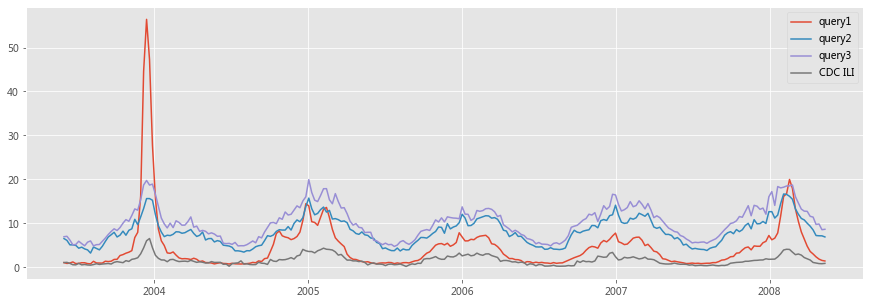

In [105]:
plt.plot(dat['date'], dat['query1'], label = 'query1')
plt.plot(dat['date'], dat['query2'], label = 'query2')
plt.plot(dat['date'], dat['query3'], label = 'query3')
plt.plot(dat['date'], y,  label = 'CDC ILI')
plt.legend()
plt.show()

In [106]:
dat['y'] = y.tolist()

In [107]:
dat.columns

Index(['date', 'query1', 'query2', 'query3', 'query4', 'query5', 'query6',
       'query7', 'query8', 'query9', 'query10', 'query11', 'query12',
       'query13', 'query14', 'query15', 'query16', 'query17', 'query18',
       'query19', 'query20', 'query21', 'query22', 'query23', 'query24',
       'query25', 'query26', 'query27', 'query28', 'query29', 'query30',
       'query31', 'query32', 'query33', 'query34', 'query35', 'query36',
       'query37', 'query38', 'query39', 'query40', 'query41', 'query42',
       'query43', 'query44', 'query45', 'y'],
      dtype='object')

In [129]:
dat['trend'] = range(1,len(dat)+1)
dat['winter'] = [1 if i.month in [12, 1, 2] else 0 for i in dat['date'] ]

In [130]:
for i in range(1, 8):
    dat["lag_{}".format(i)] = dat['y'].shift(i)
dat=dat.fillna(0)

In [131]:
def train_the_model(X):
    N = 50
    y = dat['y']
    X_train = X.iloc[:N,]
    X_test = X.iloc[N:,]
    y_train = y[:N]
    y_test = y[N:]
    date = dat['date']

    # 利用弹性网络
    from sklearn.model_selection import cross_val_score
    cv_model = ElasticNetCV(l1_ratio=0.5, eps=1e-3, n_alphas=200, fit_intercept=True, 
                            normalize=True, precompute='auto', max_iter=200, tol=0.006, cv=10, 
                            copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

    # 训练模型              
    cv_model.fit(X_train, y_train)

    # 计算最佳迭代次数、alpha和ratio
    print('最佳 alpha: %.8f'%cv_model.alpha_)
    print('最佳 l1_ratio: %.3f'%cv_model.l1_ratio_)
    print('迭代次数 %d'%cv_model.n_iter_)

    # 输出结果
    y_train_pred = cv_model.predict(X_train)
    y_pred = cv_model.predict(X_test)

    print('Train r2 score: ', r2_score(y_train_pred, y_train))
    print('Test r2 score: ', r2_score(y_test, y_pred))
    train_mse = mean_squared_error(y_train_pred, y_train)
    test_mse = mean_squared_error(y_pred, y_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print('Train RMSE: %.4f' % train_rmse)
    print('Test RMSE: %.4f' % test_rmse)

    import datetime
    plt.style.use('ggplot')

    plt.rcParams.update({'figure.figsize': (15, 5)})

    plt.plot(date, y)
    plt.plot(date[N:], y_pred)

    plt.show()
    

最佳 alpha: 0.00872249
最佳 l1_ratio: 0.500
迭代次数 192
Train r2 score:  0.9799092916160432
Test r2 score:  0.7801565516963932
Train RMSE: 0.1717
Test RMSE: 0.4824


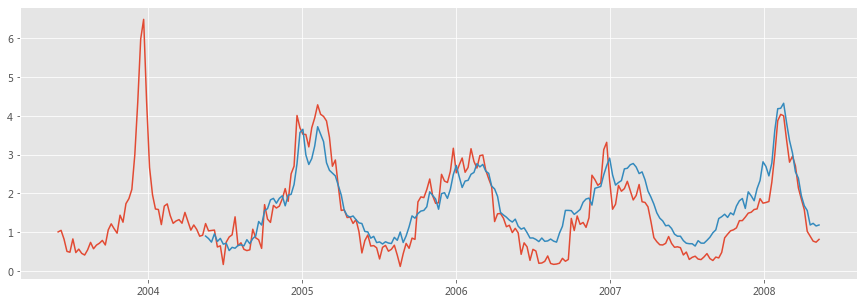

In [132]:
# only search queries
X = dat.drop(['y', 'date', 'trend','trend2', 'winter',
              'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'], axis = 1)

train_the_model(X)


In [133]:
X.columns

Index(['query1', 'query2', 'query3', 'query4', 'query5', 'query6', 'query7',
       'query8', 'query9', 'query10', 'query11', 'query12', 'query13',
       'query14', 'query15', 'query16', 'query17', 'query18', 'query19',
       'query20', 'query21', 'query22', 'query23', 'query24', 'query25',
       'query26', 'query27', 'query28', 'query29', 'query30', 'query31',
       'query32', 'query33', 'query34', 'query35', 'query36', 'query37',
       'query38', 'query39', 'query40', 'query41', 'query42', 'query43',
       'query44', 'query45'],
      dtype='object')

最佳 alpha: 0.00872249
最佳 l1_ratio: 0.500
迭代次数 192
Train r2 score:  0.9799092916160432
Test r2 score:  0.7801565516963932
Train RMSE: 0.1717
Test RMSE: 0.4824


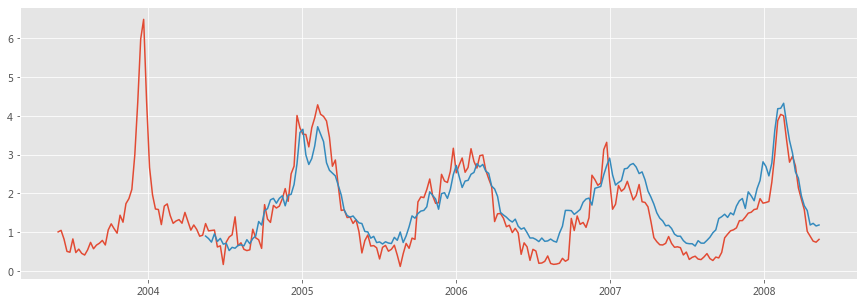

In [134]:
# search queries + trend
X = dat.drop(['y', 'date',  'winter',
              'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'], axis = 1)

train_the_model(X)

最佳 alpha: 0.00872249
最佳 l1_ratio: 0.500
迭代次数 192
Train r2 score:  0.979905989096354
Test r2 score:  0.7807360549778772
Train RMSE: 0.1717
Test RMSE: 0.4817


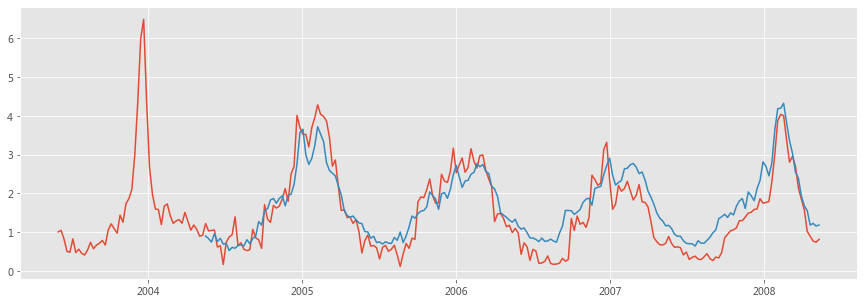

In [135]:
# search queries + trend + winter
X = dat.drop(['y', 'date',  
              'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'], axis = 1)

train_the_model(X)

最佳 alpha: 0.00903059
最佳 l1_ratio: 0.500
迭代次数 185
Train r2 score:  0.9798911422817678
Test r2 score:  0.799050088609931
Train RMSE: 0.1716
Test RMSE: 0.4612


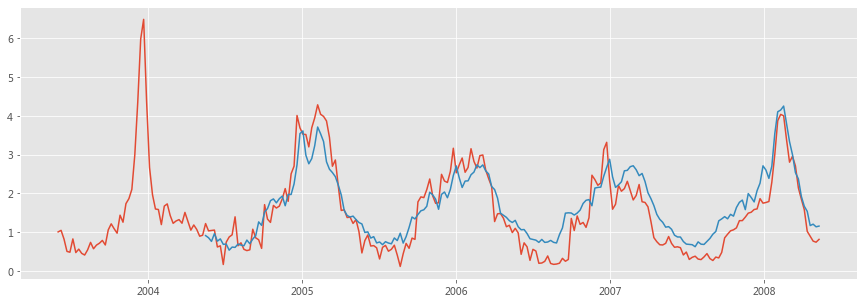

In [136]:
# search queries + trend + winter + ylag_1
X = dat.drop(['y', 'date',  'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'], axis = 1)

train_the_model(X)

最佳 alpha: 0.00182915
最佳 l1_ratio: 0.500
迭代次数 194
Train r2 score:  0.9873230484478626
Test r2 score:  0.8287448046584176
Train RMSE: 0.1405
Test RMSE: 0.4258


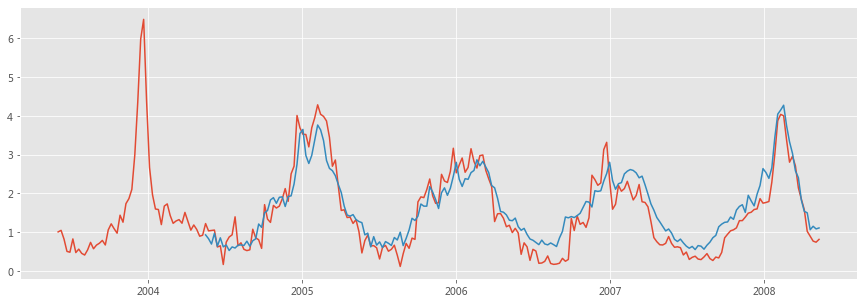

In [137]:
# search queries + trend + winter + ylag_1...+ylag_7
X = dat.drop(['y', 'date', 'trend2'], axis = 1)
train_the_model(X)

## 任务:

将train_the_model中的ElasticNetCV换成lasso或ridge来重新进行预测